In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from drift_detection.drift_detector.plotter import colorscale
from drift_detection.gemini.utils import import_dataset_hospital
from cyclops.utils.file import (
    load_pickle,
)
from drift_detection.gemini.utils import get_use_case_params, get_source_target

## Functions ##

###  Load data ###

In [3]:
DATASET = "gemini"
USE_CASE = "mortality"

use_case_params = get_use_case_params(DATASET, USE_CASE)

tab_features = load_pickle(use_case_params.TAB_FEATURES_FILE)
X = tab_features.data
X

2023-04-23 17:42:10,987 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/tab_features.pkl


,encounter_id,admit_timestamp,discharge_timestamp,age,sex,hospital_id,outcome_death,readmission,from_nursing_home_mapped,from_acute_care_institution_mapped,los_derived,prev_encounter_count,diagnosis_code,diagnosis_trajectory,admit_via_ambulance,triage_level,deathtime
0,11100040,2018-07-03 21:36:00,2018-08-03 09:35:00,84,1,SMH,False,planned_from_acute,False,False,30.499306,1,G459,G00_G99,ground,resuscitation,NaT
1,11100041,2016-12-26 18:21:00,2016-12-27 11:00:00,76,0,SMH,False,new_to_acute,False,False,0.693750,0,R55,R00_R99,ground,emergent,NaT
2,11100072,2016-08-13 15:20:00,2016-08-16 16:45:00,72,0,SMH,False,new_to_acute,False,False,3.059028,0,J441,J00_J99,no_ambulance,emergent,NaT
3,11100095,2015-12-20 18:36:00,2015-12-30 10:25:00,84,1,SMH,False,unplanned_8_to_28_day_acute,False,False,9.659028,0,T826,S00_T88,no_ambulance,emergent,NaT
4,11100097,2019-05-23 06:09:00,2019-05-28 13:07:00,65,1,SMH,False,planned_from_acute,True,False,5.290278,7,N390,N00_N99,ground,emergent,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143044,15999822,2012-04-09 21:44:00,2012-04-10 17:21:00,61,1,THPM,False,new_to_acute,False,False,0.817361,0,I635,I00_I99,ground,emergent,NaT
143045,15999864,2018-04-30 20:30:00,2018-05-06 12:46:00,58,0,THPC,False,new_to_acute,False,False,5.677778,0,L032,L00_L99,no_ambulance,emergent,NaT
143046,15999918,2019-09-18 05:59:00,2019-09-20 14:45:00,68,0,THPM,False,new_to_acute,False,False,2.365278,0,R55,R00_R99,ground,emergent,NaT
143047,15999943,2015-01-17 08:17:00,2015-01-23 11:33:00,78,0,THPM,False,nota,False,False,6.136111,0,J09,J00_J99,ground,urgent,NaT


In [ ]:
X['18_29'] = np.where(X['age'].between(18,29), 1, 0)
X['30_44'] = np.where(X['age'].between(30,44), 1, 0)
X['45_64'] = np.where(X['age'].between(45,64), 1, 0)
X['65+'] = np.where(X['age'] >= 65 , 1, 0)
X['sex'] = X['sex'].astype(np.float)
X['night_shift'] = np.where(((X['admit_timestamp'].dt.hour > 19.5) | (X['admit_timestamp'].dt.hour < 7.5)),1,0)
X['from_nursing_home_mapped'] = X['from_nursing_home_mapped'].astype(np.float)
X['from_acute_care_institution_mapped'] = X['from_acute_care_institution_mapped'].astype(np.float)

f = {
        'encounter_id' : 'count',
        'age' : 'mean',
        '18_29': 'mean',
        '30_44': 'mean',
        '45_64': 'mean',
        '65+': 'mean',
        'sex' : 'mean',
        'los_derived' : 'mean',
        'prev_encounter_count': 'mean',
        'night_shift' : 'mean',
        'from_acute_care_institution_mapped': 'mean',
        'from_nursing_home_mapped': 'mean'
}

g = X.groupby(['outcome_death','hospital_id'])
stats = g.agg(f).T
stats.to_csv('summary_stats.txt', sep='\t')
stats

/tmp/ipykernel_3119489/1098161510.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X['sex'] = X['sex'].astype(np.float)
/tmp/ipykernel_3119489/1098161510.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X['from_nursing_home_mapped'] = X['from_nursing_home_mapped'].astype(np.float)
/tmp/ipykernel_3119489/1098161510.py:8: DeprecationW

encounter_id                          143049.000000
age                                       67.810030
18_29                                      0.054750
30_44                                      0.089340
45_64                                      0.237422
65+                                        0.618487
sex                                        0.493901
los_derived                                9.431565
prev_encounter_count                       0.816468
night_shift                                0.616530
from_acute_care_institution_mapped         0.009353
from_nursing_home_mapped                   0.093807
dtype: float64

In [ ]:
diag_X = X.groupby(['outcome_death','hospital_id','diagnosis_trajectory']).size().unstack(fill_value=0).T
diag_X.to_csv('diagnosis_trajectory.txt', sep='\t')
diag_X.sum(axis=1) 

<AxesSubplot:xlabel='diagnosis_code'>

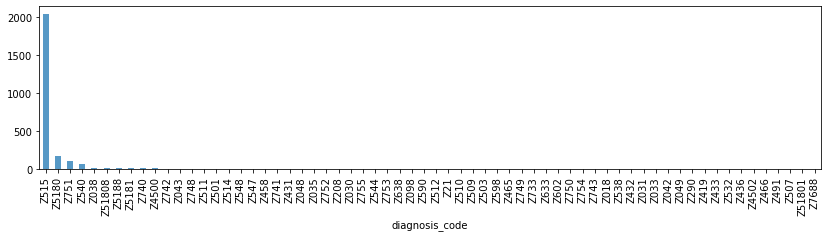

In [6]:
code_dist = X.loc[X['diagnosis_code'].str.contains("Z")]
code_dist = code_dist.groupby(['diagnosis_code']).size().sort_values(ascending=False)
code_dist.plot(figsize=(14,3), kind='bar',alpha=0.75, rot=90)

In [11]:
X.loc[X['diagnosis_code'].str.contains("Z51")].groupby(['hospital_id','outcome_death']).size().sort_values(ascending=False)

hospital_id  outcome_death
MSH          True             373
SMH          True             313
MSH          False            260
UHNTG        True             235
UHNTW        True             210
THPM         True             191
UHNTG        False            160
SBK          False            151
THPC         True             123
UHNTW        False             80
SBK          True              56
THPC         False             52
SMH          False             50
THPM         False             39
dtype: int64

In [13]:
X.columns

Index(['encounter_id', 'admit_timestamp', 'discharge_timestamp', 'age', 'sex',
       'hospital_id', 'outcome_death', 'readmission',
       'from_nursing_home_mapped', 'from_acute_care_institution_mapped',
       'los_derived', 'prev_encounter_count', 'diagnosis_code',
       'diagnosis_trajectory', 'admit_via_ambulance', 'triage_level',
       'deathtime', '18_29', '30_44', '45_64', '65+', 'night_shift'],
      dtype='object')

### Define Shift Detector and Parameters ###

In [ ]:
ShiftDetector = callable()

sign_level = 0.05
dr_technique = "PCA"
md_test = "MMD"
red_model = None
datset = "test experiment"
samples = [10, 20, 50, 100, 200, 500, 1000, 2000]
sample = samples[5]
orig_dims = X_s_tr.shape[1:]
print("Building shift detector...")
sd = ShiftDetector(dr_technique, md_test, sign_level, red_model, sample, datset)

#### Drift from 2019 to 2019 ####

In [ ]:
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_tr, y_s_tr, X_s_val[:sample, :], y_s_val[:sample], orig_dims
)
print(p_val, dist)

X = pd.DataFrame(X_s_val, columns=features)
y = pd.DataFrame(y_s_val, columns=[LABEL])
stats_2019_val = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

#### Drift from 2019 to 2020 ####

In [ ]:
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_t[:sample, :], y_t[:sample], orig_dims
)
print(p_val, dist)

X = pd.DataFrame(X_t, columns=features)
y = pd.DataFrame(y_t, columns=[LABEL])
stats_2020 = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

In [ ]:
datasets = ["2019_tr", "2019_val", "2020"]
stats = pd.concat([stats_2019_tr, stats_2019_val, stats_2020], keys=datasets, axis=1)
fig = plt.figure(figsize=(20, 8))
brightness = [1.5, 1.25, 1.0, 0.75, 0.5]
colors = [
    "#2196f3",
    "#f44336",
    "#9c27b0",
    "#64dd17",
    "#009688",
    "#ff9800",
    "#795548",
    "#607d8b",
]
n = len(datasets)
w = 0.3
x = np.arange(0, len(stats.index.values[1:]))
for i, dataset in enumerate(datasets):
    position = x + (w * (1 - n) / 2) + i * w
    plt.errorbar(
        position,
        stats[dataset]["cases"]["mean"].values[1:],
        stats[dataset]["cases"]["std"].values[1:],
        fmt="o",
        ecolor="red",
        color=colorscale(colors[i], brightness[0]),
    )
    plt.errorbar(
        position + 0.15,
        stats[dataset]["controls"]["mean"].values[1:],
        stats[dataset]["controls"]["std"].values[1:],
        fmt="o",
        ecolor="black",
        color=colorscale(colors[i], brightness[0]),
    )
    plt.xticks(position - 0.2, stats.index.values[1:])
plt.tick_params(rotation=60)
plt.show()

#### Knockout Shift ####

In [ ]:
import_dataset_year = callable()
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year(
    "los", "2020"
)
shift = "ko_shift_0.5"
apply_shift = callable()
X_ko, y_ko = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_ko[:sample, :], y_ko[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_ko, columns=features)
y = pd.DataFrame(y_ko, columns=[LABEL])
stats_ko = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

#### Small Gaussian Noise Shift ####

In [ ]:
shift = "small_gn_shift_0.1"
X_sgn, y_sgn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_sgn[:sample, :], y_sgn[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_sgn, columns=features)
y = pd.DataFrame(y_sgn, columns=[LABEL])
stats_sgn = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

#### Large Gaussian Noise Shift ####

In [ ]:
shift = "large_gn_shift_1.0"
X_lgn, y_lgn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_lgn[:sample, :], y_lgn[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_lgn, columns=features)
y = pd.DataFrame(y_lgn, columns=[LABEL])
stats_lgn = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

#### Multiway Feature Association Shift ####

In [ ]:
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year(
    "los", "2020"
)
shift = "mfa_shift_0.5"
X_mfa, y_mfa = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_mfa[:sample, :], y_mfa[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_mfa, columns=features)
y = pd.DataFrame(y_mfa, columns=[LABEL])
stats_mfa = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

#### Changepoint Shift ####

In [ ]:
(X_s_tr, y_s_tr), (X_s_val, y_s_val), (X_t, y_t), orig_dims = import_dataset_year(
    "los", "2020"
)
shift = "cp_shift_0.75"
X_cp, y_cp = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_cp[:sample, :], y_cp[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_mfa, columns=features)
y = pd.DataFrame(y_mfa, columns=[LABEL])
stats_cp = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

### Binary ###

In [ ]:
shift = "large_bn_shift_1.0"
X_bn, y_bn = apply_shift(X_s_tr, y_s_tr, X_s_val, y_s_val, shift)
p_val, dist, red_dim, red_model, t1_acc, t2_acc = sd.detect_data_shift(
    X_s_tr, y_s_tr, X_s_val, y_s_val, X_bn[:sample, :], y_bn[:sample], orig_dims
)
print(p_val, dist)
X = pd.DataFrame(X_bn, columns=features)
y = pd.DataFrame(y_bn, columns=[LABEL])
stats_bn = summary_stats(X, y, LABEL)
plot_admin(X, y, LABEL)

In [ ]:
datasets = ["2019_val", "ko", "bn"]
stats = pd.concat([stats_2019_val, stats_ko, stats_bn], keys=datasets, axis=1)
fig = plt.figure(figsize=(20, 8))
brightness = [1.5, 1.25, 1.0, 0.75, 0.5]
colors = [
    "#2196f3",
    "#f44336",
    "#9c27b0",
    "#64dd17",
    "#009688",
    "#ff9800",
    "#795548",
    "#607d8b",
]
n = len(datasets)
w = 0.3
x = np.arange(0, len(stats.index.values[1:]))
for i, dataset in enumerate(datasets):
    position = x + (w * (1 - n) / 2) + i * w
    plt.errorbar(
        position,
        stats[dataset]["cases"]["mean"].values[1:],
        stats[dataset]["cases"]["std"].values[1:],
        fmt="o",
        ecolor="red",
        color=colorscale(colors[i], brightness[0]),
    )
    plt.errorbar(
        position + 0.15,
        stats[dataset]["controls"]["mean"].values[1:],
        stats[dataset]["controls"]["std"].values[1:],
        fmt="o",
        ecolor="black",
        color=colorscale(colors[i], brightness[0]),
    )
    plt.xticks(position - 0.2, stats.index.values[1:])
plt.tick_params(rotation=60)
plt.show()